# Dataset Class

In [2]:
import torch
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from  Dataset.visualize_keypoint import *


#from src.dataset import *

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()

# Dataloader


Our dataset contains the following features:
- **image_id :** (*input, int*) image identification, different animal samples on the same image share the same *image_id*.
- **image :**(*input, array[1024*1024*3]*) image data of the sample.
- **keypoints :** (*output, array[20*3]*) list of individual keypoints, which are lists of three values : [$x_{pos}$, $y_{pos}$, conf].
- **bbox :** (*output, array[4]*) coordinates [$x$,$y$] for diagonal corners defining the bounding box of the animal.
- **label :** (*output, int*) class id of the sample.

In [3]:

# cow sheep horse cat dog
labels = ['dog', 'cat', 'sheep', 'horse', 'cow']

class AnimalPoseDataset(Dataset):
    def __init__ (self, json_file, root_dir, transform=None):
        self.keypoints_frame = json.load(open(json_file))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.keypoints_frame["annotations"])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        anno_dict = self.keypoints_frame
        img_id = anno_dict["annotations"][idx]["image_id"]
        image_map = anno_dict["images"]
        annotations = anno_dict["annotations"]

        imagename = image_map[str(annotations[idx]["image_id"])]
        bbox = annotations[idx]["bbox"]
        keypoints = annotations[idx]["keypoints"]
        label = labels[annotations[idx]["category_id"]-1]
        image_path = os.path.join(self.root_dir, imagename)
        image = cv2.imread(image_path)
        
        sample = {'image_id': img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def draw(self, sample):
        image = sample['image']
        bbox = sample['bbox']
        xmin, ymin, xmax, ymax = bbox 
        image = draw_bbox(image, xmin, ymin, xmax, ymax, random_color())
        image = draw_keypoint(image, sample['keypoints'])
        return image


def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

  return result

class Rescale (object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__ (self, sample):
        img_id, image, keypoints, bbox = sample['image_id'],sample['image'], sample['keypoints'], sample['bbox']
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        # scale the image
        img = transform.resize(image, (new_h, new_w))
        # scale the keypoints
        scaled_keypoints = []
        for kp in keypoints:
            new_x = int(kp[0] * new_w / w)
            new_y = int(kp[1] * new_h / h)
            scaled_keypoints.append([new_x, new_y, kp[2]])
        # scale the bbox
        xmin, ymin, xmax, ymax = bbox
        xmin = int(xmin * new_w / w)
        xmax = int(xmax * new_w / w)
        ymin = int(ymin * new_h / h)
        ymax = int(ymax * new_h / h)
        bbox = [xmin, ymin, xmax, ymax]
        

        return {'image_id':img_id, 'image': img, 'keypoints': scaled_keypoints, 'bbox':bbox, 'label':sample['label']}
        
class SDA(object):
    
    def __init__(self, nb_bodyparts, tolerance=20):
        # number of body parts to add to the image
        self.nb_bodyparts = nb_bodyparts
        self.bodypart_pool = []
        self.tolerance=tolerance

    def __call__(self, sample):
        img_id, image, keypoints, bbox = sample['image_id'], sample['image'], sample['keypoints'], sample['bbox']
        image, keypoints, bodyparts = self.crop_bodypart(image, keypoints)
        self.bodypart_pool.extend(bodyparts)
        
        # add the body parts to the image
        for i in range(self.nb_bodyparts):
            image = self.add_bodyparts(image)
        
        return {'image_id':img_id, 'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':sample['label']}

    def crop_bodypart(self, image, keypoints):
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        draw_keypoint(mask, keypoints)
        # find the contours in the mask
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # crop the different body parts and store them 
        bodyparts = []
        for i in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[i])
            bodyparts.append(image[y-self.tolerance:y+h+self.tolerance, x-self.tolerance:x+w+self.tolerance])
        # return the image with the body parts and the keypoints
        return image, keypoints, bodyparts
    
    def add_bodyparts(self, image):        
        # randomly select a body part
        bodypart = random.choice(self.bodypart_pool)
        # randomly select an angle
        #angle = random.randint(0, 360)        
        # rotate the body part
        #bodypart = rotate_image(bodypart, angle)
        h,w,_ = bodypart.shape

        # randomly select a position for the body part
        x = random.randint(0, image.shape[1] - w)
        y = random.randint(0, image.shape[0] - h)
        
        image[y:y+h, x:x+w] = cv2.addWeighted(image[y:y+h, x:x+w], 0, bodypart, 1, 0)
        return image


    def show_bodyparts(self):     
        for i in range(len(self.bodypart_pool)):
            plt.imshow(self.bodypart_pool[i])
            plt.show()

In [4]:
dataset = AnimalPoseDataset(json_file='Dataset/keypoints.json', 
                            root_dir='Dataset/images/',
                            transform=transforms.Compose([
                                                        Rescale((640,640)),
                                                        SDA(nb_bodyparts=3, tolerance=10)]))

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)
sample = {'image_id':None, 'image': None, 'keypoints': None, 'bbox':None, 'label':None}
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])

    if i_batch == 3:
        sample['image_id'] = sample_batched['image_id']
        sample['image'] = sample_batched['image']
        sample['keypoints'] = sample_batched['keypoints']
        sample['bbox'] = sample_batched['bbox']
        sample['label'] = sample_batched['label']
        break


print(sample['image_id'])

print("keypoints: ", sample['keypoints'])

print("bbox :", sample['bbox'])

print("label :",sample['label'])

print(sample['image'].size())

0 torch.Size([10, 640, 640, 3]) ['cat', 'dog', 'sheep', 'cat', 'cat', 'dog', 'cow', 'sheep', 'sheep', 'sheep']
1 torch.Size([10, 640, 640, 3]) ['cat', 'dog', 'sheep', 'horse', 'dog', 'horse', 'dog', 'sheep', 'horse', 'cow']
2 torch.Size([10, 640, 640, 3]) ['dog', 'sheep', 'sheep', 'cat', 'dog', 'sheep', 'dog', 'cat', 'sheep', 'sheep']
3 torch.Size([10, 640, 640, 3]) ['dog', 'cow', 'dog', 'cow', 'dog', 'cow', 'dog', 'cat', 'sheep', 'cat']
tensor([1031,  534, 3479, 3884, 4092, 3370, 3164, 3054, 3212, 1242])
keypoints:  [[tensor([156, 331, 234, 384, 214,   0,   0, 284,   0,   0]), tensor([254, 254, 366, 260, 168,   0,   0, 288,   0,   0]), tensor([1, 1, 1, 1, 1, 0, 0, 1, 0, 0])], [tensor([126, 247, 176,   0,   0,   0, 386, 252,   0,   0]), tensor([251, 264, 370,   0,   0,   0, 401, 273,   0,   0]), tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0])], [tensor([140, 309, 193, 153, 176,   0, 337, 262,   0,   0]), tensor([287, 373, 418, 471, 194,   0, 390, 303,   0,   0]), tensor([1, 1, 1, 1, 1, 0, 1, 1,

# YOLOv8 net

- **k** : kernel size
- **s** : stride, determines the step size the convolution filter moves across the input image.
- **p** : padding, used to control the spatial dimensions of the ouptut feature map by adding extra pixels around the input image or feature map before applying the convolution

Special components:
- **Split**: divides the input feature map into two or more separate feature maps along a specified axis(usually channel axis). This can be useful for processing parts of the feature map separately of feeding them into different parallel sub-nets
- **Bottleneck**: design pattern often used to reduce the dimensionality of feature maps, followed by an expansion to the original dimensionality. This is usually achieved using a series of conv layers with varying kernels sizes and channel dimensions. Helps in reducing the models computational complexity while preserving relevant features
- **Concat**: the concatenation op combines multiple feature maps along a specified axis. This is useful for merging information from different sources or resolutions withing the network, which can help improve the model's ability ot learn complex features and relationships


Validation loss decreased (100000.000000 --> 40232.542969).  Saving model ...


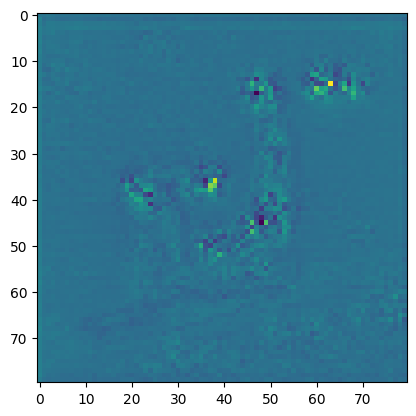

Epoch: 1 	Batch: 1 	Loss: 40232.542969 	Remaining: 611
Validation loss decreased (40232.542969 --> 38053.375000).  Saving model ...
Epoch: 1 	Batch: 2 	Loss: 38053.375000 	Remaining: 610
Epoch: 1 	Batch: 3 	Loss: 144180.921875 	Remaining: 609
Epoch: 1 	Batch: 4 	Loss: 198104.171875 	Remaining: 608
Epoch: 1 	Batch: 5 	Loss: 40130.140625 	Remaining: 607
Epoch: 1 	Batch: 6 	Loss: 39330.718750 	Remaining: 606
Epoch: 1 	Batch: 7 	Loss: 39722.742188 	Remaining: 605
Validation loss decreased (38053.375000 --> 37948.140625).  Saving model ...
Epoch: 1 	Batch: 8 	Loss: 37948.140625 	Remaining: 604
Epoch: 1 	Batch: 9 	Loss: 38116.910156 	Remaining: 603
Epoch: 1 	Batch: 10 	Loss: 38019.960938 	Remaining: 602
Validation loss decreased (37948.140625 --> 37412.000000).  Saving model ...
Epoch: 1 	Batch: 11 	Loss: 37412.000000 	Remaining: 601
Epoch: 1 	Batch: 12 	Loss: 39118.234375 	Remaining: 600
Epoch: 1 	Batch: 13 	Loss: 42461.039062 	Remaining: 599
Epoch: 1 	Batch: 14 	Loss: 38114.710938 	Remaini

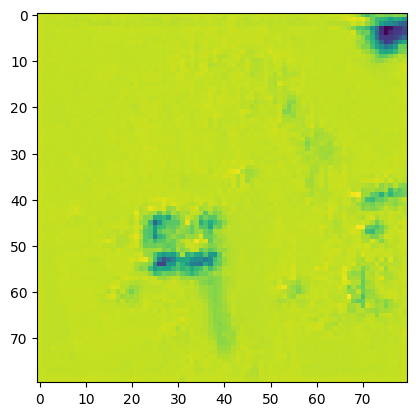

Epoch: 1 	Batch: 31 	Loss: 40497.738281 	Remaining: 581
Epoch: 1 	Batch: 32 	Loss: 39989.199219 	Remaining: 580
Epoch: 1 	Batch: 33 	Loss: 41904.226562 	Remaining: 579
Epoch: 1 	Batch: 34 	Loss: 39189.335938 	Remaining: 578
Epoch: 1 	Batch: 35 	Loss: 37556.617188 	Remaining: 577
Epoch: 1 	Batch: 36 	Loss: 40728.050781 	Remaining: 576
Epoch: 1 	Batch: 37 	Loss: 39352.093750 	Remaining: 575
Epoch: 1 	Batch: 38 	Loss: 37562.777344 	Remaining: 574
Epoch: 1 	Batch: 39 	Loss: 36762.554688 	Remaining: 573
Epoch: 1 	Batch: 40 	Loss: 39206.148438 	Remaining: 572
Validation loss decreased (35863.035156 --> 35067.617188).  Saving model ...
Epoch: 1 	Batch: 41 	Loss: 35067.617188 	Remaining: 571
Epoch: 1 	Batch: 42 	Loss: 39087.507812 	Remaining: 570
Epoch: 1 	Batch: 43 	Loss: 37571.351562 	Remaining: 569
Epoch: 1 	Batch: 44 	Loss: 42312.988281 	Remaining: 568
Epoch: 1 	Batch: 45 	Loss: 37974.105469 	Remaining: 567
Epoch: 1 	Batch: 46 	Loss: 37311.906250 	Remaining: 566
Epoch: 1 	Batch: 47 	Loss: 

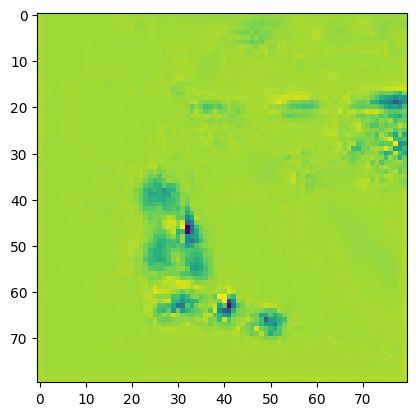

Epoch: 1 	Batch: 61 	Loss: 41342.656250 	Remaining: 551
Validation loss decreased (34808.542969 --> 34378.828125).  Saving model ...
Epoch: 1 	Batch: 62 	Loss: 34378.828125 	Remaining: 550
Epoch: 1 	Batch: 63 	Loss: 41551.859375 	Remaining: 549
Epoch: 1 	Batch: 64 	Loss: 34838.750000 	Remaining: 548
Epoch: 1 	Batch: 65 	Loss: 38814.460938 	Remaining: 547
Epoch: 1 	Batch: 66 	Loss: 40742.792969 	Remaining: 546
Epoch: 1 	Batch: 67 	Loss: 40618.550781 	Remaining: 545
Epoch: 1 	Batch: 68 	Loss: 40020.359375 	Remaining: 544
Epoch: 1 	Batch: 69 	Loss: 38297.238281 	Remaining: 543
Epoch: 1 	Batch: 70 	Loss: 41413.988281 	Remaining: 542
Epoch: 1 	Batch: 71 	Loss: 41964.933594 	Remaining: 541
Epoch: 1 	Batch: 72 	Loss: 37557.511719 	Remaining: 540
Epoch: 1 	Batch: 73 	Loss: 34848.457031 	Remaining: 539
Epoch: 1 	Batch: 74 	Loss: 38530.503906 	Remaining: 538
Validation loss decreased (34378.828125 --> 33594.148438).  Saving model ...
Epoch: 1 	Batch: 75 	Loss: 33594.148438 	Remaining: 537
Epoch:

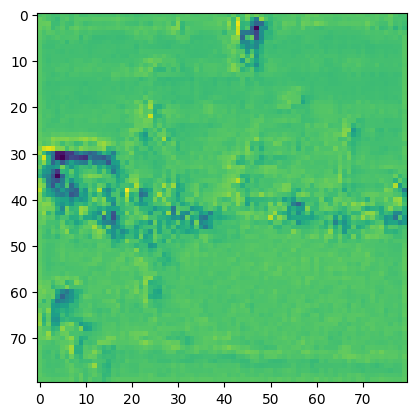

Epoch: 1 	Batch: 91 	Loss: 37750.648438 	Remaining: 521
Epoch: 1 	Batch: 92 	Loss: 39933.039062 	Remaining: 520
Epoch: 1 	Batch: 93 	Loss: 37132.902344 	Remaining: 519
Epoch: 1 	Batch: 94 	Loss: 43761.687500 	Remaining: 518
Epoch: 1 	Batch: 95 	Loss: 34257.382812 	Remaining: 517
Epoch: 1 	Batch: 96 	Loss: 38203.859375 	Remaining: 516
Epoch: 1 	Batch: 97 	Loss: 40630.179688 	Remaining: 515
Epoch: 1 	Batch: 98 	Loss: 37033.636719 	Remaining: 514
Epoch: 1 	Batch: 99 	Loss: 36569.648438 	Remaining: 513
Epoch: 1 	Batch: 100 	Loss: 37400.468750 	Remaining: 512
Epoch: 1 	Batch: 101 	Loss: 41559.570312 	Remaining: 511
Epoch: 1 	Batch: 102 	Loss: 44423.664062 	Remaining: 510
Epoch: 1 	Batch: 103 	Loss: 38740.035156 	Remaining: 509
Epoch: 1 	Batch: 104 	Loss: 38985.457031 	Remaining: 508
Epoch: 1 	Batch: 105 	Loss: 41499.609375 	Remaining: 507
Epoch: 1 	Batch: 106 	Loss: 37766.289062 	Remaining: 506
Epoch: 1 	Batch: 107 	Loss: 40515.679688 	Remaining: 505
Epoch: 1 	Batch: 108 	Loss: 37575.121094

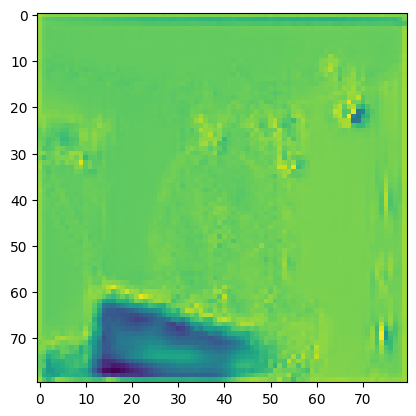

Epoch: 1 	Batch: 121 	Loss: 39220.585938 	Remaining: 491
Epoch: 1 	Batch: 122 	Loss: 38812.750000 	Remaining: 490
Epoch: 1 	Batch: 123 	Loss: 36466.476562 	Remaining: 489
Epoch: 1 	Batch: 124 	Loss: 35543.429688 	Remaining: 488
Epoch: 1 	Batch: 125 	Loss: 37131.917969 	Remaining: 487
Epoch: 1 	Batch: 126 	Loss: 35667.882812 	Remaining: 486
Validation loss decreased (33179.078125 --> 33109.898438).  Saving model ...
Epoch: 1 	Batch: 127 	Loss: 33109.898438 	Remaining: 485
Epoch: 1 	Batch: 128 	Loss: 34085.074219 	Remaining: 484
Epoch: 1 	Batch: 129 	Loss: 36305.656250 	Remaining: 483
Epoch: 1 	Batch: 130 	Loss: 41375.710938 	Remaining: 482
Epoch: 1 	Batch: 131 	Loss: 42347.375000 	Remaining: 481
Epoch: 1 	Batch: 132 	Loss: 40203.128906 	Remaining: 480
Epoch: 1 	Batch: 133 	Loss: 40509.011719 	Remaining: 479
Epoch: 1 	Batch: 134 	Loss: 38009.722656 	Remaining: 478
Epoch: 1 	Batch: 135 	Loss: 36076.625000 	Remaining: 477
Epoch: 1 	Batch: 136 	Loss: 33227.855469 	Remaining: 476
Epoch: 1 	B

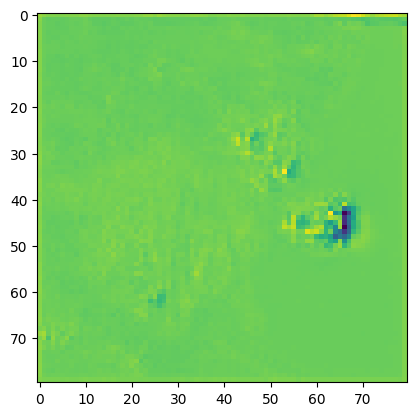

Epoch: 1 	Batch: 151 	Loss: 42299.796875 	Remaining: 461
Epoch: 1 	Batch: 152 	Loss: 39037.500000 	Remaining: 460
Epoch: 1 	Batch: 153 	Loss: 37149.343750 	Remaining: 459
Epoch: 1 	Batch: 154 	Loss: 37978.886719 	Remaining: 458
Epoch: 1 	Batch: 155 	Loss: 43967.476562 	Remaining: 457
Epoch: 1 	Batch: 156 	Loss: 35720.960938 	Remaining: 456
Epoch: 1 	Batch: 157 	Loss: 36454.640625 	Remaining: 455
Epoch: 1 	Batch: 158 	Loss: 37835.203125 	Remaining: 454
Epoch: 1 	Batch: 159 	Loss: 38841.898438 	Remaining: 453
Epoch: 1 	Batch: 160 	Loss: 43295.726562 	Remaining: 452
Epoch: 1 	Batch: 161 	Loss: 37794.000000 	Remaining: 451
Epoch: 1 	Batch: 162 	Loss: 38465.781250 	Remaining: 450
Epoch: 1 	Batch: 163 	Loss: 40792.703125 	Remaining: 449
Epoch: 1 	Batch: 164 	Loss: 38348.621094 	Remaining: 448
Epoch: 1 	Batch: 165 	Loss: 39286.984375 	Remaining: 447
Epoch: 1 	Batch: 166 	Loss: 38881.738281 	Remaining: 446
Epoch: 1 	Batch: 167 	Loss: 38169.867188 	Remaining: 445
Epoch: 1 	Batch: 168 	Loss: 371

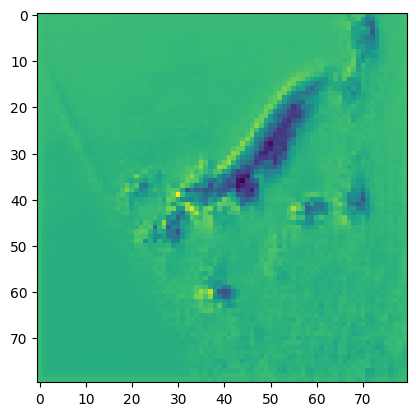

Epoch: 1 	Batch: 181 	Loss: 42047.890625 	Remaining: 431
Epoch: 1 	Batch: 182 	Loss: 41135.722656 	Remaining: 430
Epoch: 1 	Batch: 183 	Loss: 36249.687500 	Remaining: 429
Epoch: 1 	Batch: 184 	Loss: 40107.148438 	Remaining: 428
Epoch: 1 	Batch: 185 	Loss: 39073.875000 	Remaining: 427
Epoch: 1 	Batch: 186 	Loss: 36791.074219 	Remaining: 426
Epoch: 1 	Batch: 187 	Loss: 42294.394531 	Remaining: 425
Epoch: 1 	Batch: 188 	Loss: 38909.503906 	Remaining: 424
Epoch: 1 	Batch: 189 	Loss: 40221.421875 	Remaining: 423
Epoch: 1 	Batch: 190 	Loss: 39876.804688 	Remaining: 422
Epoch: 1 	Batch: 191 	Loss: 35625.929688 	Remaining: 421
Epoch: 1 	Batch: 192 	Loss: 41773.800781 	Remaining: 420
Epoch: 1 	Batch: 193 	Loss: 38552.710938 	Remaining: 419
Epoch: 1 	Batch: 194 	Loss: 37715.500000 	Remaining: 418
Epoch: 1 	Batch: 195 	Loss: 38668.234375 	Remaining: 417
Epoch: 1 	Batch: 196 	Loss: 37473.332031 	Remaining: 416


In [7]:
### Detail block modules
# Conv
class Conv(nn.Module):
    def __init__(self, k, s, p, c_in, c_out):
        super().__init__()
        # 2d conv layer
        self.conv = nn.Conv2d(c_in, c_out, k, s, p)
        # batch normalization
        self.bn = nn.BatchNorm2d(c_out)
        # SiLU activation
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class Bottleneck(nn.Module):
    def __init__(self, shortcut, h, w , c_in):
        super().__init__()
        self.conv = Conv(k=3, s=1, p=1, c_in=c_in, c_out=c_in//2)
        self.conv1 = Conv(k=3, s=1, p=1, c_in=c_in//2, c_out=c_in)
        self.shortcut = shortcut

    def forward(self, x):
        if self.shortcut:
            xp = self.conv1(self.conv(x))
            x = x + xp
        else:
            x = self.conv(x)
            x = self.conv1(x)        
        return x

class SPPF(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.conv = Conv(k=1, s=1, p=0, c_in=c_in,c_out=c_in)    
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=32, padding=2) 

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.maxpool(x1)
        x3 = self.maxpool(x2)
        x4 = self.maxpool(x3)
        xtot = x1 + x2 + x3 + x4
        #x = torch.cat((x4, xtot), dim=1)
        x = self.conv(xtot)
        return x

class C2f(nn.Module):
    def __init__(self, shortcut, c_in, c_out, h, w, n):
        super().__init__()
        self.conv1 = Conv(k=1, s=1, p=0, c_in=c_in, c_out=c_out)
        self.conv2 = Conv(k=1, s=1, p=0, c_in=int(0.5*(n+2)*c_out), c_out=c_out)
        self.bottleneck = Bottleneck(shortcut=shortcut, h=h, w=w, c_in=c_out//2)
        self.n = n
        self.cout = c_out
        self.cin = c_in

    def forward(self, x):
        x = self.conv1(x)
        
        # split the input into half and the other half channels
        split_x = torch.split(x, x.size(1)//2, dim=1)        
        # current bottleneck
        bn = split_x[0]
        # list of bottlenecks to be stacked
        bn_x = []
        bn_x.append(bn)        
        # iterate through the number of bottlenecks to be stacked
        for i in range(self.n):
            # apply the bottleneck to the first half channels and store them in bn_x
            bn = self.bottleneck(bn)
            bn_x.append(bn)
               
        # concatenate the first half channels with the second half channels
        bn_x.append(split_x[1])
        # concatenate the bottlenecks
        x = torch.cat(bn_x, dim=1)
        x = self.conv2(x)                
        return x

class Detect(nn.Module):
    def __init__(self, num_classes, reg_max, c_in):
        super().__init__()
        self.conv = Conv(k=3, s=1, p=1, c_in=c_in, c_out=c_in)
        self.conv2d_bbox = nn.Conv2d(kernel_size=1, stride=1, padding=0, in_channels=c_in, out_channels=4*reg_max)
        self.conv2d_cls = nn.Conv2d(kernel_size=1, stride=1, padding=0, in_channels=c_in, out_channels=num_classes)
        self.linear = nn.Linear(in_features=6400, out_features=4)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv(x)
        x_cls = self.conv2d_cls(x)
        x_bbox = self.conv2d_bbox(x)
        #x_bbox = self.calculate_bbox(x_bbox)
        return x_cls, x_bbox

    def calculate_bbox(self, x):
        x_pred = torch.sigmoid(x[:,0,:, :])
        y_pred = torch.sigmoid(x[:,1,:, :])
        w_pred = torch.exp(x[:,2,:, :])
        h_pred = torch.exp(x[:,3,:, :])
        bbox = torch.cat([x_pred, y_pred, w_pred, h_pred], dim=1)
        return bbox

# Main Network architecture
class BBoxNet(nn.Module):
    def __init__(self, w, r, d):
        super(BBoxNet, self).__init__()
    # backbone network modules
        self.conv_0_p1 = Conv(k=3, s=2, p=1, c_in=3, c_out=int(64*w))
        self.conv_1_p2 = Conv(k=3, s=2, p=1, c_in=int(64*w), c_out=int(128*w))
        self.c2f_2 = C2f(shortcut=True, h=160, w=160, n=int(3*d), c_in=int(128*w), c_out=int(128*w))
        self.conv_3_p3 = Conv(k=3, s=2, p=1, c_in=int(128*w), c_out=int(256*w))
        self.c2f_4 = C2f(shortcut=True, h=80, w=80, n=int(6*d), c_in=int(256*w), c_out=int(256*w))
        self.conv_5_p4 = Conv(k=3, s=2, p=1, c_in=int(256*w), c_out=int(512*w))
        self.c2f_6 = C2f(shortcut=True, h=40, w=40, n=int(6*d), c_in=int(512*w), c_out=int(512*w))
        self.conv_7_p5 = Conv(k=3, s=2, p=1, c_in=int(512*w), c_out=int(512*w*r))
        self.c2f_8 = C2f(shortcut=True, h=20, w=20, n=int(3*d), c_in=int(512*w*r), c_out=int(512*r*w))
        self.sppf_9 = SPPF(c_in=int(512*w*r))

    # head network modules
        self.upsample_10 = nn.Upsample(size=(40,40), mode='bilinear', align_corners=False)
        self.concat_11 = torch.cat
        self.c2f_12 = C2f(shortcut=False, c_in=int(512*w*(1+r)), c_out=int(512*w), h=40, w=40, n=int(3*d))
        self.upsample_resolution_13a = nn.Upsample(size=(80,80), mode='bilinear', align_corners=False)
        self.upsample_channels_13b = nn.Conv2d(in_channels=int(512*w), out_channels=int(256*w), kernel_size=1)
        self.concat_14 = torch.cat
        self.c2f_15 = C2f(shortcut=False, c_in=int(512*w), c_out=int(256*w), h=80, w=80, n=int(3*d))
        self.conv_16_p3 = Conv(k=3, s=2, p=1, c_in=int(256*w), c_out=int(256*w))
        self.concat_17 = torch.cat
        # ISSUE HERE, THE ARCHITECTURE OUTPUT CHANNEL SIZE IS PROBABLY WRONG, AS THE CONCATENATION DOES NOT INCREASE THE CHANNEL SIZE
        #self.c2f_18 = C2f(shortcut=False, c_in=int(512*w), c_out=int(512*w), h=40, w=40, n=int(3*d))
        self.c2f_18 = C2f(shortcut=False, c_in=192, c_out=192, h=40, w=40, n=int(3*d))
        self.conv_19 = Conv(k=3, s=2, p=1, c_in=192, c_out=192)
        self.concat_20 = torch.cat
        #self.c2f_21 = C2f(shortcut=False, c_in=int(512*w*(1+r)), c_out=int(512*w), h=20, w=20, n=int(3*d))
        self.c2f_21 = C2f(shortcut=False, c_in=448, c_out=int(512*w), h=20, w=20, n=int(3*d))
    
    # output layers
        self.detect1 = Detect(num_classes=6, reg_max=1, c_in=int(256*w))
        self.detect2 = Detect(num_classes=6, reg_max=1, c_in=192)
        self.detect3 = Detect(num_classes=6, reg_max=1, c_in=int(512*w))

    def forward(self,x):
    # backbone pass
        x = self.conv_0_p1(x)
        x = self.conv_1_p2(x)
        x = self.c2f_2(x)
        x = self.conv_3_p3(x)
        x = self.c2f_4(x)
        # save for concat later
        x_4 = x
        
        x = self.conv_5_p4(x)
        x = self.c2f_6(x)
        
        # save for concat later
        x_6 = x
        x = self.conv_7_p5(x)
        x = self.c2f_8(x)
        x = self.sppf_9(x)
        x_9 = x

    # head pass
        # first brancH
        x = self.upsample_10(x)
        x = self.concat_11((x, x_6), dim=1)
        x = self.c2f_12(x)  
        x_12 = x
        x = self.upsample_resolution_13a(x)
        x = self.upsample_channels_13b(x)
        x = self.concat_14((x, x_4), dim=1)
        x = self.c2f_15(x) 
        x_detect1 = x
        
    # second branch
        x = self.conv_16_p3(x)
        # CHECK CHANNEL ISSUE HEREISSUE HERE
        x = self.concat_17((x_12, x), dim=1)
        x = self.c2f_18(x)
        x_detect2 = x
        x = self.conv_19(x)
        # ISSUE PROPAGATES HERE ALSO
        x = self.concat_20((x, x_9), dim=1)
        x = self.c2f_21(x)
        x_detect3 = x
    
    # output layers
        x_cls1, x_bbox1 = self.detect1(x_detect1)
        x_cls2, x_bbox2 = self.detect2(x_detect2)
        x_cls3, x_bbox3 = self.detect3(x_detect3)        

        return [x_cls1, x_bbox1, x_cls2, x_bbox2, x_cls3, x_bbox3]

def calculate_iou(pred_bboxes, gt_bboxes):
     # Calculate intersection
    inter_xmin = torch.max(pred_bboxes[..., 0], gt_bboxes[..., 0])
    inter_ymin = torch.max(pred_bboxes[..., 1], gt_bboxes[..., 1])
    inter_xmax = torch.min(pred_bboxes[..., 2], gt_bboxes[..., 2])
    inter_ymax = torch.min(pred_bboxes[..., 3], gt_bboxes[..., 3])

    inter_width = torch.clamp(inter_xmax - inter_xmin, min=0)
    inter_height = torch.clamp(inter_ymax - inter_ymin, min=0)
    inter_area = inter_width * inter_height

    # Calculate union
    pred_area = (pred_bboxes[..., 2] - pred_bboxes[..., 0]) * (pred_bboxes[..., 3] - pred_bboxes[..., 1])
    gt_area = (gt_bboxes[..., 2] - gt_bboxes[..., 0]) * (gt_bboxes[..., 3] - gt_bboxes[..., 1])
    union_area = pred_area + gt_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area
    return iou
    
def bbox_regression_loss(pred_bboxes, gt_bboxes):
    # Reshape the predicted bounding boxes to (batch, 4, -1)
    pred_bboxes = pred_bboxes.view(pred_bboxes.size(0), 4, -1)
    # Convert the predicted bounding boxes to absolute coordinates
    pred_bboxes_xy = torch.sigmoid(pred_bboxes[:, :2, :])
    pred_bboxes_wh = torch.exp(pred_bboxes[:, 2:, :])
    # Combine the x, y, width, and height to create the final predicted bounding boxes
    pred_bboxes_abs = torch.cat((pred_bboxes_xy, pred_bboxes_wh), dim=1)
    iou_loss = torch.zeros((pred_bboxes_abs.shape[0], pred_bboxes_abs.shape[2]))
    id_list = torch.zeros((pred_bboxes_abs.shape[0], pred_bboxes_abs.shape[1]))

    for sample in range(pred_bboxes_abs.shape[0]):
        for bbox in range(pred_bboxes_abs.shape[2]):
            iou = calculate_iou(pred_bboxes_abs[sample, :, bbox], gt_bboxes[sample, :])
            loss = 1 - iou
            iou_loss[sample, bbox] = loss

        # get the index of the predicted bounding box with the highest IoU
        max_iou, max_iou_idx = torch.max(iou_loss[sample], dim=0)
        # if the IoU is greater than 0.5, then the predicted bounding box is a true positive
        if max_iou > 0.5:
            id_list[sample, :] = pred_bboxes_abs[sample, :, max_iou_idx]

    # Calculate the loss
    loss = torch.sum(torch.abs(id_list - gt_bboxes))
    return loss, id_list

    
# define the training function
def train_net(net, train_loader, n_epochs, optimizer, scheduler, criterion):
    # loop over the number of epochs
    best_loss = 100000
    for epoch in range(n_epochs):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0

        # set the model to training mode
        net.train()
        for i_batch, data in enumerate(dataloader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data = data.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = net(data['image'].permute(0,3,1,2).float())
            
            # calculate the batch loss
            bbox = torch.stack([t for t in data['bbox']], dim=1)
            loss1, _ = criterion(output[1], bbox)
            loss2,_ = criterion(output[3], bbox)
            loss3,_ = criterion(output[5], bbox)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss = loss1 + loss2 + loss3
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss

            train_loss += loss.item()*data['image'].size(0)
            # save the model if validation loss has decreased
            if loss.item() < best_loss:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss, loss.item()))
                torch.save(net.state_dict(), 'model.pt')
                best_loss = loss.item()
            
            # show the feature map
            if i_batch%30 == 0:
                plt.imshow(output[0][0,0,:,:].detach().cpu().numpy())
                plt.show()



            # print train loss in percentage, and remaining batches in epoch
            print('Epoch: {} \tBatch: {} \tLoss: {:.6f} \tRemaining: {}'.format(epoch+1, i_batch+1, loss.item(), len(train_loader)-i_batch-1))
            

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

        # step the scheduler
        scheduler.step()
net = BBoxNet(w=0.25, r=2, d=0.34)
net = net.to(device)
criterion = bbox_regression_loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
n_epochs = 10
train_net(net, dataloader, n_epochs, optimizer, scheduler, criterion)